# **Comparing Baseline and Recurrent Transformers on Short-Only and Long-Only SST-2 Subsets**

This notebook examines how input length affects model performance by comparing two architectures—a **baseline Transformer** and a **Recurrent Transformer**—on the SST-2 sentiment classification task.

To isolate the effect of sequence length, we construct two controlled subsets:

* **Short subset:** the shortest 30% of samples
* **Long subset:** the longest 30% of samples

We then **train each model separately on the short-only and long-only datasets**, allowing us to observe:

1. **How each architecture performs when trained on short vs. long inputs**
2. **Whether recurrent mechanisms provide advantages on long sequences**
3. **Whether models trained on short data generalize poorly to long data, and vice versa**

No full-data training is performed—the goal is to directly examine how architectural differences interact with input length under controlled training regimes.

This setup provides a clear and focused comparison of **length robustness** between the two model families.

## Experiments on Long Texts (Long-Only Subset)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Model configurations
BASELINE_CONFIG = {
    'hidden_size': 384,
    'num_hidden_layers': 6,
    'num_attention_heads': 6,
    'intermediate_size': 1536,
    'dropout_prob': 0.1,
    'use_flash_attention': True,
    'use_swiglu': True,
    'use_rope': True,
    'use_rms_norm': True
}

RECURRENT_CONFIG = {
    'hidden_size': 256,
    'num_hidden_layers': 3,
    'recurrent_depth': 2,  # Effective depth: 3 × 2 = 6
    'num_attention_heads': 4,
    'intermediate_size': 1024,
    'dropout_prob': 0.1,
    'residual_scale': 0.5,
    'use_flash_attention': True,
    'use_swiglu': True,
    'use_rope': True,
    'use_rms_norm': True
}

TRAINING_CONFIG = {
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 3e-5,
    'warmup_steps': 100,
    'eval_steps': 50,
    'max_length': 128
}


In [4]:
# Load data
from training.utils import prepare_sst2_data, load_tokenizer

tokenizer = load_tokenizer('bert-base-uncased')
train_loader, val_loader, test_loader = prepare_sst2_data(
    data_dir='data/processed_length_splits_sst2/long',
    tokenizer=tokenizer,
    batch_size=TRAINING_CONFIG['batch_size'],
    max_length=TRAINING_CONFIG['max_length']
)

train_size = len(train_loader) * TRAINING_CONFIG['batch_size']
val_size = len(val_loader) * TRAINING_CONFIG['batch_size']
print(f"Dataset sizes - Train: {train_size}, Validation: {val_size}")

Loaded 6398 samples from data/processed_length_splits_sst2/long\sst2_train.pkl
Loaded 336 samples from data/processed_length_splits_sst2/long\sst2_internal_val.pkl
Loaded 87 samples from data/processed_length_splits_sst2/long\sst2_val.pkl
Dataset sizes - Train: 6400, Validation: 336


In [ ]:
# Initialize models
from models.baseline import BaselineModel, BaselineConfig
from models.recurrent import RecurrentModel, RecurrentConfig

# Baseline model
baseline_config = BaselineConfig(
    vocab_size=30522,
    hidden_size=BASELINE_CONFIG['hidden_size'],
    num_hidden_layers=BASELINE_CONFIG['num_hidden_layers'],
    num_attention_heads=BASELINE_CONFIG['num_attention_heads'],
    intermediate_size=BASELINE_CONFIG['intermediate_size'],
    hidden_dropout_prob=BASELINE_CONFIG['dropout_prob'],
    attention_probs_dropout_prob=BASELINE_CONFIG['dropout_prob'],
    num_labels=2,
    **{k: v for k, v in BASELINE_CONFIG.items() if k.startswith('use_')}
)

# Recurrent model
recurrent_config = RecurrentConfig(
    vocab_size=30522,
    hidden_size=RECURRENT_CONFIG['hidden_size'],
    num_hidden_layers=RECURRENT_CONFIG['num_hidden_layers'],
    recurrent_depth=RECURRENT_CONFIG['recurrent_depth'],
    num_attention_heads=RECURRENT_CONFIG['num_attention_heads'],
    intermediate_size=RECURRENT_CONFIG['intermediate_size'],
    hidden_dropout_prob=RECURRENT_CONFIG['dropout_prob'],
    attention_probs_dropout_prob=RECURRENT_CONFIG['dropout_prob'],
    residual_scale=RECURRENT_CONFIG['residual_scale'],
    num_labels=2,
    **{k: v for k, v in RECURRENT_CONFIG.items() if k.startswith('use_')}
)

baseline_model = BaselineModel(baseline_config).to(device)
recurrent_model = RecurrentModel(recurrent_config).to(device)

# Model statistics
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

baseline_params = count_parameters(baseline_model)
recurrent_params = count_parameters(recurrent_model)

print(f"Baseline: {baseline_params:,} parameters ({baseline_params/1e6:.1f}M)")
print(f"Recurrent: {recurrent_params:,} parameters ({recurrent_params/1e6:.1f}M)")
print(f"Parameter reduction: {(1 - recurrent_params/baseline_params)*100:.1f}%")


Baseline: 25,912,706 parameters (25.9M)
Recurrent: 10,972,162 parameters (11.0M)
Parameter reduction: 57.7%


In [ ]:
# Train both models with early stopping
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import copy
import torch

def train_model(model, name, num_epochs=TRAINING_CONFIG['num_epochs'], patience=3, min_delta=0.001):
    optimizer = AdamW(model.parameters(), lr=TRAINING_CONFIG['learning_rate'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_losses = []

        for batch in tqdm(train_loader, desc=f"{name} Epoch {epoch+1}/{num_epochs}", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()

            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )

            loss = outputs['loss']
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['labels']
                )

                val_losses.append(outputs['loss'].item())
                predictions = outputs['logits'].argmax(dim=-1)
                val_correct += (predictions == batch['labels']).sum().item()
                val_total += batch['labels'].size(0)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        val_acc = val_correct / val_total
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0

            print(f"{name} Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}, Acc={val_acc:.4f} *")

            # Save best model at this moment
            save_path = f"{name}_best_model.pt"
            torch.save(best_model_state, save_path)
            # print(f"{name}: Saved new best model → {save_path}")   # Optional log

        else:
            patience_counter += 1
            print(f"{name} Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}, Acc={val_acc:.4f}")

        if patience_counter >= patience:
            print(f"{name}: Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"{name}: Loaded best model with val_loss={best_val_loss:.4f}")

    return history

# Train models
print("Training with early stopping (patience=3)")
print("-" * 50)
baseline_history = train_model(baseline_model, "Baseline")
print()
recurrent_history = train_model(recurrent_model, "Recurrent")


Training with early stopping (patience=3)
--------------------------------------------------


Baseline Epoch 1: Train=0.6690, Val=0.4844, Acc=0.7589 *


Baseline Epoch 2: Train=0.3448, Val=0.4995, Acc=0.8423


Baseline Epoch 3: Train=0.2287, Val=0.5255, Acc=0.8720


Baseline Epoch 4: Train=0.1636, Val=0.6947, Acc=0.8869
Baseline: Early stopping triggered at epoch 4
Baseline: Loaded best model with val_loss=0.4844



Recurrent Epoch 1: Train=0.6812, Val=0.5735, Acc=0.7470 *


Recurrent Epoch 2: Train=0.3821, Val=0.3954, Acc=0.8571 *


Recurrent Epoch 3: Train=0.2053, Val=0.3499, Acc=0.8839 *


Recurrent Epoch 4: Train=0.1594, Val=0.4608, Acc=0.8929


Recurrent Epoch 5: Train=0.1307, Val=0.5592, Acc=0.9018
Recurrent: Loaded best model with val_loss=0.3499


In [ ]:
# Evaluate models
def evaluate_model(model, loader):
    model.eval()

    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    inference_times = []

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            # Measure inference time
            start_time = time.time()
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            inference_times.append((time.time() - start_time) * 1000 / batch['input_ids'].size(0))

            predictions = outputs['logits'].argmax(dim=-1)
            total_correct += (predictions == batch['labels']).sum().item()
            total_samples += batch['labels'].size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    accuracy = total_correct / total_samples
    avg_inference_time = np.mean(inference_times)

    # Calculate F1 score
    from sklearn.metrics import f1_score, precision_score, recall_score
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)

    return {
    'accuracy': accuracy,
    'f1': f1,
    'precision': precision,
    'recall': recall,
    'inference_time_ms': avg_inference_time,
    'y_true': all_labels,
    'y_pred': all_predictions}

# Evaluate on test set
baseline_metrics = evaluate_model(baseline_model, test_loader)
recurrent_metrics = evaluate_model(recurrent_model, test_loader)

# Model sizes
baseline_size_mb = baseline_params * 4 / (1024 * 1024)  # 4 bytes per parameter
recurrent_size_mb = recurrent_params * 4 / (1024 * 1024)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Recurrent'],
    'Parameters': [baseline_params, recurrent_params],
    'Size (MB)': [baseline_size_mb, recurrent_size_mb],
    'Accuracy': [baseline_metrics['accuracy'], recurrent_metrics['accuracy']],
    'F1': [baseline_metrics['f1'], recurrent_metrics['f1']],
    'Precision': [baseline_metrics['precision'], recurrent_metrics['precision']],
    'Recall': [baseline_metrics['recall'], recurrent_metrics['recall']],
    'Inference (ms)': [baseline_metrics['inference_time_ms'], recurrent_metrics['inference_time_ms']]
})

print(comparison_df.round(4))


       Model  Parameters  Size (MB)  Accuracy      F1  Precision  Recall  \
0   Baseline    25912706    98.8491    0.6437  0.6931     0.6140  0.7955   
1  Recurrent    10972162    41.8555    0.6437  0.6076     0.6857  0.5455   

   Inference (ms)  
0          1.2027  
1          0.5512  


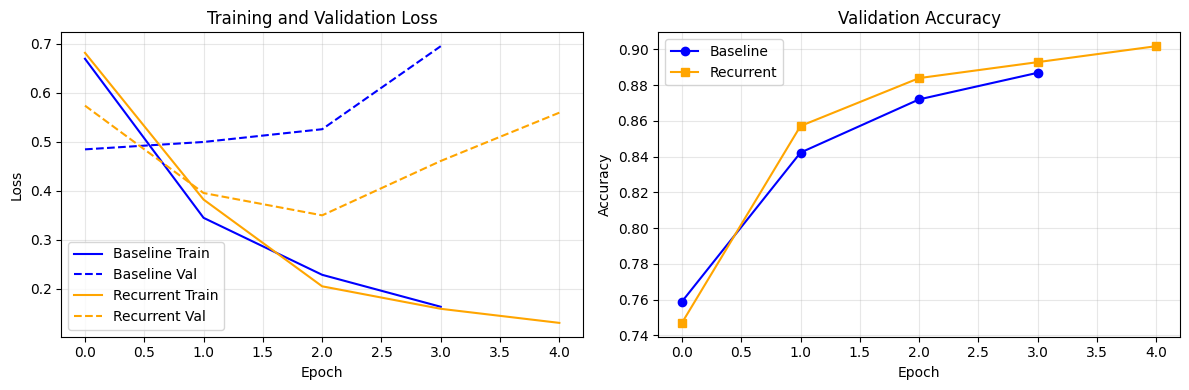

In [ ]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(baseline_history['train_loss'], label='Baseline Train', color='blue', linestyle='-')
axes[0].plot(baseline_history['val_loss'], label='Baseline Val', color='blue', linestyle='--')
axes[0].plot(recurrent_history['train_loss'], label='Recurrent Train', color='orange', linestyle='-')
axes[0].plot(recurrent_history['val_loss'], label='Recurrent Val', color='orange', linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(baseline_history['val_acc'], label='Baseline', color='blue', marker='o')
axes[1].plot(recurrent_history['val_acc'], label='Recurrent', color='orange', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


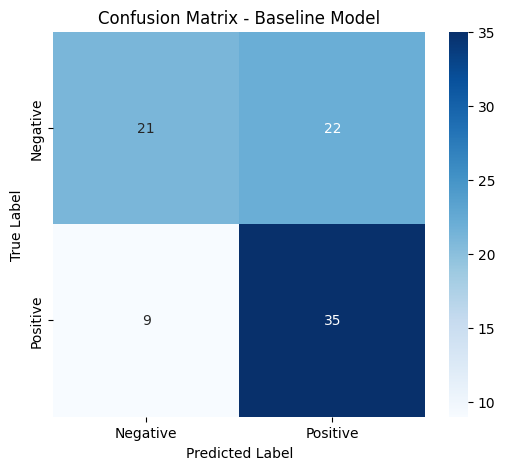

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# baseline model
y_true = baseline_metrics['y_true']
y_pred = baseline_metrics['y_pred']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Baseline Model")
plt.show()


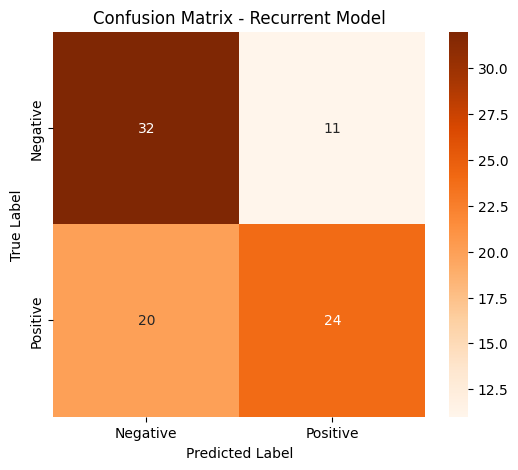

In [ ]:
# recurrent model
y_true = recurrent_metrics['y_true']
y_pred = recurrent_metrics['y_pred']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Recurrent Model")
plt.show()


## Experiments on Short Texts (Short-Only Subset)

In [5]:
# Load data
from training.utils import prepare_sst2_data, load_tokenizer

tokenizer = load_tokenizer('bert-base-uncased')
train_loader, val_loader, test_loader = prepare_sst2_data(
    data_dir='data/processed_length_splits_sst2/short',
    tokenizer=tokenizer,
    batch_size=TRAINING_CONFIG['batch_size'],
    max_length=TRAINING_CONFIG['max_length']
)

train_size = len(train_loader) * TRAINING_CONFIG['batch_size']
val_size = len(val_loader) * TRAINING_CONFIG['batch_size']
print(f"Dataset sizes - Train: {train_size}, Validation: {val_size}")

Loaded 6398 samples from data/processed_length_splits_sst2/short\sst2_train.pkl
Loaded 336 samples from data/processed_length_splits_sst2/short\sst2_internal_val.pkl
Loaded 87 samples from data/processed_length_splits_sst2/short\sst2_val.pkl
Dataset sizes - Train: 6400, Validation: 336


In [ ]:
# Train both models with early stopping
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import copy
import torch

def train_model(model, name, num_epochs=TRAINING_CONFIG['num_epochs'], patience=3, min_delta=0.001):
    optimizer = AdamW(model.parameters(), lr=TRAINING_CONFIG['learning_rate'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_losses = []

        for batch in tqdm(train_loader, desc=f"{name} Epoch {epoch+1}/{num_epochs}", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()

            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )

            loss = outputs['loss']
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['labels']
                )

                val_losses.append(outputs['loss'].item())
                predictions = outputs['logits'].argmax(dim=-1)
                val_correct += (predictions == batch['labels']).sum().item()
                val_total += batch['labels'].size(0)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        val_acc = val_correct / val_total
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0

            print(f"{name} Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}, Acc={val_acc:.4f} *")

            # Save best model at this moment
            save_path = f"{name}_best_model.pt"
            torch.save(best_model_state, save_path)
            # print(f"{name}: Saved new best model → {save_path}")   # Optional log

        else:
            patience_counter += 1
            print(f"{name} Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}, Acc={val_acc:.4f}")

        if patience_counter >= patience:
            print(f"{name}: Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"{name}: Loaded best model with val_loss={best_val_loss:.4f}")

    return history

# Train models
print("Training with early stopping (patience=3)")
print("-" * 50)
baseline_history = train_model(baseline_model, "Baseline")
print()
recurrent_history = train_model(recurrent_model, "Recurrent")


Training with early stopping (patience=3)
--------------------------------------------------


Baseline Epoch 1: Train=0.6815, Val=0.5993, Acc=0.7113 *


Baseline Epoch 2: Train=0.5161, Val=0.5545, Acc=0.7173 *


Baseline Epoch 3: Train=0.3216, Val=0.6075, Acc=0.7857


Baseline Epoch 4: Train=0.2120, Val=0.7281, Acc=0.8095


Baseline Epoch 5: Train=0.1553, Val=1.0333, Acc=0.7887
Baseline: Early stopping triggered at epoch 5
Baseline: Loaded best model with val_loss=0.5545



Recurrent Epoch 1: Train=0.6893, Val=0.6340, Acc=0.6429 *


Recurrent Epoch 2: Train=0.5573, Val=0.4819, Acc=0.7768 *


Recurrent Epoch 3: Train=0.3637, Val=0.5885, Acc=0.7708


Recurrent Epoch 4: Train=0.2438, Val=0.6540, Acc=0.8065


Recurrent Epoch 5: Train=0.1833, Val=0.8401, Acc=0.8185
Recurrent: Early stopping triggered at epoch 5
Recurrent: Loaded best model with val_loss=0.4819


In [ ]:
# Evaluate models
def evaluate_model(model, loader):
    model.eval()

    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    inference_times = []

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            # Measure inference time
            start_time = time.time()
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            inference_times.append((time.time() - start_time) * 1000 / batch['input_ids'].size(0))

            predictions = outputs['logits'].argmax(dim=-1)
            total_correct += (predictions == batch['labels']).sum().item()
            total_samples += batch['labels'].size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    accuracy = total_correct / total_samples
    avg_inference_time = np.mean(inference_times)

    # Calculate F1 score
    from sklearn.metrics import f1_score, precision_score, recall_score
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)

    return {
    'accuracy': accuracy,
    'f1': f1,
    'precision': precision,
    'recall': recall,
    'inference_time_ms': avg_inference_time,
    'y_true': all_labels,
    'y_pred': all_predictions}

# Evaluate on test set
baseline_metrics = evaluate_model(baseline_model, test_loader)
recurrent_metrics = evaluate_model(recurrent_model, test_loader)

# Model sizes
baseline_size_mb = baseline_params * 4 / (1024 * 1024)  # 4 bytes per parameter
recurrent_size_mb = recurrent_params * 4 / (1024 * 1024)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Recurrent'],
    'Parameters': [baseline_params, recurrent_params],
    'Size (MB)': [baseline_size_mb, recurrent_size_mb],
    'Accuracy': [baseline_metrics['accuracy'], recurrent_metrics['accuracy']],
    'F1': [baseline_metrics['f1'], recurrent_metrics['f1']],
    'Precision': [baseline_metrics['precision'], recurrent_metrics['precision']],
    'Recall': [baseline_metrics['recall'], recurrent_metrics['recall']],
    'Inference (ms)': [baseline_metrics['inference_time_ms'], recurrent_metrics['inference_time_ms']]
})

print(comparison_df.round(4))


       Model  Parameters  Size (MB)  Accuracy      F1  Precision  Recall  \
0   Baseline    25912706    98.8491    0.7701  0.6970     0.8214  0.6053   
1  Recurrent    10972162    41.8555    0.7471  0.7027     0.7222  0.6842   

   Inference (ms)  
0          0.4446  
1          0.4069  


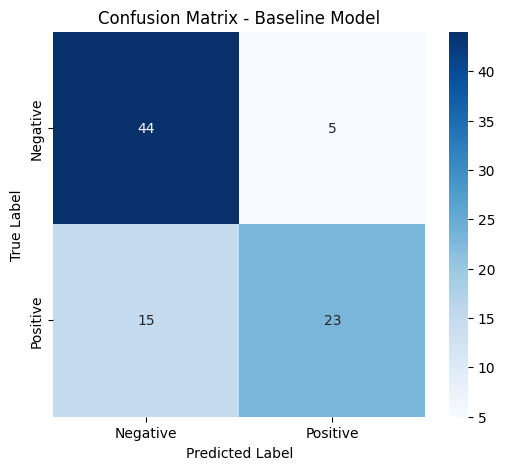

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# baseline model
y_true = baseline_metrics['y_true']
y_pred = baseline_metrics['y_pred']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Baseline Model")
plt.show()


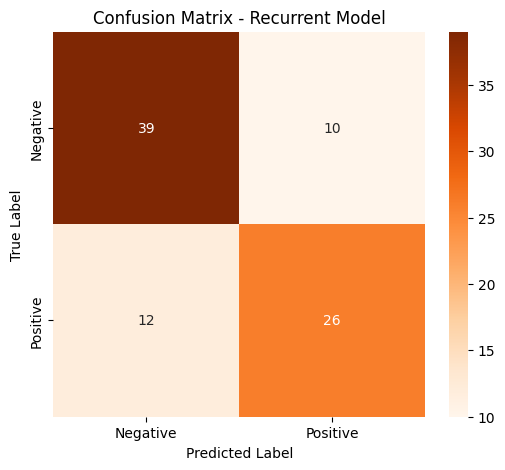

In [ ]:
# recurrent model
y_true = recurrent_metrics['y_true']
y_pred = recurrent_metrics['y_pred']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Recurrent Model")
plt.show()
